In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import wrds
import psycopg2 
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats


db = wrds.Connection(wrds_username='dachxiu')

Loading library list...
Done


In [2]:
db.list_tables(library="comp")

['anncomp',
 'codirfin',
 'colev',
 'coperol',
 'deferredcomp',
 'directorcomp',
 'ex_black',
 'ex_header',
 'exnames',
 'ltawdtab',
 'outstandingawards',
 'pension',
 'person',
 'planbasedawards',
 'stgrttab',
 'filings',
 'aco_amda',
 'aco_imda',
 'aco_indfnta',
 'aco_indfntq',
 'aco_indfntytd',
 'aco_indsta',
 'aco_indstq',
 'aco_indstytd',
 'aco_notesa',
 'aco_notesq',
 'aco_notessa',
 'aco_notesytd',
 'aco_pnfnda',
 'aco_pnfndq',
 'aco_pnfndytd',
 'aco_pnfnta',
 'aco_pnfntq',
 'aco_pnfntytd',
 'aco_transa',
 'aco_transq',
 'aco_transsa',
 'aco_transytd',
 'adsprate',
 'asec_amda',
 'asec_imda',
 'asec_notesa',
 'asec_notesq',
 'asec_transa',
 'asec_transq',
 'co_aacctchg',
 'co_aaudit',
 'co_adesind',
 'co_adjfact',
 'co_afnd1',
 'co_afnd2',
 'co_afnddc1',
 'co_afnddc2',
 'co_afntind1',
 'co_afntind2',
 'co_ainvval',
 'co_amkt',
 'co_busdescl',
 'co_cotype',
 'co_filedate',
 'co_fortune',
 'co_hgic',
 'co_iacctchg',
 'co_iaudit',
 'co_idesind',
 'co_ifndq',
 'co_ifndsa',
 'co_ifnd

In [3]:
db.describe_table(library="comp", table="funda")

Approximately 804874 rows in comp.funda.


,name,nullable,type
0,gvkey,True,VARCHAR(6)
1,datadate,True,DATE
2,fyear,True,DOUBLE PRECISION
3,indfmt,True,VARCHAR(12)
4,consol,True,VARCHAR(2)
...,...,...,...
943,au,True,VARCHAR(8)
944,auop,True,VARCHAR(8)
945,auopic,True,VARCHAR(1)
946,ceoso,True,VARCHAR(1)


comp = conn.raw_sql("""
                    select gvkey, datadate, at, pstkl, txditc,
                    pstkrv, seq, pstk
                    from comp.funda
                    where indfmt='INDL' 
                    and datafmt='STD'
                    and popsrc='D'
                    and consol='C'
                    and datadate >= '01/01/1959'
                    """)

https://wrds-web.wharton.upenn.edu/wrds/tools/variable.cfm?library_id=7&file_id=95302

gvkey 	Char	6	Global Company Key
datadate 	Num	8	Data Date
at 	Num	8	Assets - Total
pstkl 	Num	8	Preferred Stock - Liquidating Value
seq 	Num	8	Stockholders Equity - Parent
pstk 	Num	8	Preferred/Preference Stock (Capital) - Total

In [4]:
comp = db.raw_sql("""
                    select gvkey, datadate, at, pstkl, txditc,
                    pstkrv, seq, pstk
                    from comp.funda
                    where indfmt='INDL' 
                    and datafmt='STD'
                    and popsrc='D'
                    and consol='C'
                    and datadate >= '01/01/1970'
                    """)

In [5]:
comp['datadate']

0         1970-12-31
1         1971-12-31
2         1972-12-31
3         1973-12-31
4         1974-12-31
             ...    
473525    2016-12-31
473526    2017-12-31
473527    2018-12-31
473528    2017-09-30
473529    2018-09-30
Name: datadate, Length: 473530, dtype: object

In [6]:
comp['datadate']=pd.to_datetime(comp['datadate'])

In [7]:
comp['datadate']

0        1970-12-31
1        1971-12-31
2        1972-12-31
3        1973-12-31
4        1974-12-31
            ...    
473525   2016-12-31
473526   2017-12-31
473527   2018-12-31
473528   2017-09-30
473529   2018-09-30
Name: datadate, Length: 473530, dtype: datetime64[ns]

In [8]:
comp['year']=comp['datadate'].dt.year

In [9]:
comp['year']

0         1970
1         1971
2         1972
3         1973
4         1974
          ... 
473525    2016
473526    2017
473527    2018
473528    2017
473529    2018
Name: year, Length: 473530, dtype: int64

In [10]:
comp['ps']=np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
comp['ps']=np.where(comp['ps'].isnull(),comp['pstk'], comp['ps'])
comp['ps']=np.where(comp['ps'].isnull(),0,comp['ps'])

In [11]:
comp['ps']

0         0.000
1         0.000
2         0.000
3         0.000
4         2.069
          ...  
473525    0.000
473526    0.000
473527    0.000
473528    0.000
473529    0.000
Name: ps, Length: 473530, dtype: float64

In [12]:
comp['txditc']=comp['txditc'].fillna(0)

In [13]:
comp['txditc']

0          0.000
1          0.000
2          0.288
3          0.231
4          0.091
           ...  
473525     0.900
473526    11.000
473527    58.300
473528     0.000
473529     0.000
Name: txditc, Length: 473530, dtype: float64

In [14]:
comp['be']=comp['seq']+comp['txditc']-comp['ps']
comp['be']=np.where(comp['be']>0, comp['be'], np.nan)

In [15]:
comp['be']

0           10.544
1            8.382
2            7.309
3            8.798
4            8.279
            ...   
473525    1342.700
473526    1418.900
473527    1742.800
473528       8.494
473529       9.475
Name: be, Length: 473530, dtype: float64

In [16]:
comp=comp.sort_values(by=['gvkey','datadate'])

In [17]:
comp['count']=comp.groupby(['gvkey']).cumcount()

In [18]:
comp['count']

0         0
1         1
2         2
3         3
4         4
         ..
473525    3
473526    4
473527    5
473528    0
473529    1
Name: count, Length: 473530, dtype: int64

In [19]:
comp=comp[['gvkey','datadate','year','be','count']]

In [20]:
comp

,gvkey,datadate,year,be,count
0,001000,1970-12-31,1970,10.544,0
1,001000,1971-12-31,1971,8.382,1
2,001000,1972-12-31,1972,7.309,2
3,001000,1973-12-31,1973,8.798,3
4,001000,1974-12-31,1974,8.279,4
...,...,...,...,...,...
473525,328795,2016-12-31,2016,1342.700,3
473526,328795,2017-12-31,2017,1418.900,4
473527,328795,2018-12-31,2018,1742.800,5
473528,330227,2017-09-30,2017,8.494,0


###第60行往下CRSP数据读取及处理

In [21]:
crsp_m = db.raw_sql("""
                      select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
                      a.ret, a.retx, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1970' and '01/01/2019'
                      and b.exchcd between 1 and 3
                      """) 

In [22]:
crsp_m

,permno,permco,date,shrcd,exchcd,ret,retx,shrout,prc
0,10000.0,7952.0,1986-01-31,10.0,3.0,NaN,NaN,3680.0,-4.375
1,10001.0,7953.0,1991-03-28,11.0,3.0,-0.011538,-0.025641,1054.0,9.500
2,10001.0,7953.0,1991-04-30,11.0,3.0,0.039474,0.039474,1054.0,-9.875
3,10001.0,7953.0,1991-05-31,11.0,3.0,0.000000,0.000000,1054.0,-9.875
4,10001.0,7953.0,1991-06-28,11.0,3.0,0.078481,0.063291,1073.0,10.500
...,...,...,...,...,...,...,...,...,...
3666440,10065.0,20023.0,1970-11-30,14.0,1.0,0.070000,0.070000,11456.0,13.375
3666441,10065.0,20023.0,1970-12-31,14.0,1.0,0.046729,0.046729,11909.0,14.000
3666442,10065.0,20023.0,1971-01-29,14.0,1.0,0.048929,0.032500,11909.0,14.125
3666443,10065.0,20023.0,1971-02-26,14.0,1.0,-0.001770,-0.008850,11909.0,14.000


In [23]:
db.describe_table(library="crsp", table="msf")

Approximately 4509850 rows in crsp.msf.


,name,nullable,type
0,cusip,True,VARCHAR(8)
1,permno,True,DOUBLE PRECISION
2,permco,True,DOUBLE PRECISION
3,issuno,True,DOUBLE PRECISION
4,hexcd,True,DOUBLE PRECISION
5,hsiccd,True,DOUBLE PRECISION
6,date,True,DATE
7,bidlo,True,DOUBLE PRECISION
8,askhi,True,DOUBLE PRECISION
9,prc,True,DOUBLE PRECISION


In [24]:
crsp_m[['permco','permno','shrcd','exchcd']]

,permco,permno,shrcd,exchcd
0,7952.0,10000.0,10.0,3.0
1,7953.0,10001.0,11.0,3.0
2,7953.0,10001.0,11.0,3.0
3,7953.0,10001.0,11.0,3.0
4,7953.0,10001.0,11.0,3.0
...,...,...,...,...
3666440,20023.0,10065.0,14.0,1.0
3666441,20023.0,10065.0,14.0,1.0
3666442,20023.0,10065.0,14.0,1.0
3666443,20023.0,10065.0,14.0,1.0


In [25]:
crsp_m[['permco','permno','shrcd','exchcd']]=crsp_m[['permco','permno','shrcd','exchcd']].astype(int)


In [26]:
crsp_m[['permco','permno','shrcd','exchcd']]

,permco,permno,shrcd,exchcd
0,7952,10000,10,3
1,7953,10001,11,3
2,7953,10001,11,3
3,7953,10001,11,3
4,7953,10001,11,3
...,...,...,...,...
3666440,20023,10065,14,1
3666441,20023,10065,14,1
3666442,20023,10065,14,1
3666443,20023,10065,14,1


In [27]:
crsp_m['date']=pd.to_datetime(crsp_m['date'])

In [28]:
crsp_m['jdate']=crsp_m['date']+MonthEnd(0)

In [29]:
crsp_m['date']

0         1986-01-31
1         1991-03-28
2         1991-04-30
3         1991-05-31
4         1991-06-28
             ...    
3666440   1970-11-30
3666441   1970-12-31
3666442   1971-01-29
3666443   1971-02-26
3666444   1971-03-31
Name: date, Length: 3666445, dtype: datetime64[ns]

In [30]:
crsp_m['jdate']

0         1986-01-31
1         1991-03-31
2         1991-04-30
3         1991-05-31
4         1991-06-30
             ...    
3666440   1970-11-30
3666441   1970-12-31
3666442   1971-01-31
3666443   1971-02-28
3666444   1971-03-31
Name: jdate, Length: 3666445, dtype: datetime64[ns]

In [31]:
MonthEnd(0)

<0 * MonthEnds>

In [32]:
dlret = db.raw_sql("""
                     select permno, dlret, dlstdt 
                     from crsp.msedelist
                     """)

In [33]:
dlret.permno=dlret.permno.astype(int)
dlret['dlstdt']=pd.to_datetime(dlret['dlstdt'])
dlret['jdate']=dlret['dlstdt']+MonthEnd(0)

In [34]:
crsp = pd.merge(crsp_m, dlret, how='left',on=['permno','jdate'])

In [35]:
crsp

,permno,permco,date,shrcd,exchcd,ret,retx,shrout,prc,jdate,dlret,dlstdt
0,10000,7952,1986-01-31,10,3,NaN,NaN,3680.0,-4.375,1986-01-31,NaN,NaT
1,10001,7953,1991-03-28,11,3,-0.011538,-0.025641,1054.0,9.500,1991-03-31,NaN,NaT
2,10001,7953,1991-04-30,11,3,0.039474,0.039474,1054.0,-9.875,1991-04-30,NaN,NaT
3,10001,7953,1991-05-31,11,3,0.000000,0.000000,1054.0,-9.875,1991-05-31,NaN,NaT
4,10001,7953,1991-06-28,11,3,0.078481,0.063291,1073.0,10.500,1991-06-30,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...
3666440,10065,20023,1970-11-30,14,1,0.070000,0.070000,11456.0,13.375,1970-11-30,NaN,NaT
3666441,10065,20023,1970-12-31,14,1,0.046729,0.046729,11909.0,14.000,1970-12-31,NaN,NaT
3666442,10065,20023,1971-01-29,14,1,0.048929,0.032500,11909.0,14.125,1971-01-31,NaN,NaT
3666443,10065,20023,1971-02-26,14,1,-0.001770,-0.008850,11909.0,14.000,1971-02-28,NaN,NaT


In [36]:
crsp['dlret']=crsp['dlret'].fillna(0)

In [37]:
crsp

,permno,permco,date,shrcd,exchcd,ret,retx,shrout,prc,jdate,dlret,dlstdt
0,10000,7952,1986-01-31,10,3,NaN,NaN,3680.0,-4.375,1986-01-31,0.0,NaT
1,10001,7953,1991-03-28,11,3,-0.011538,-0.025641,1054.0,9.500,1991-03-31,0.0,NaT
2,10001,7953,1991-04-30,11,3,0.039474,0.039474,1054.0,-9.875,1991-04-30,0.0,NaT
3,10001,7953,1991-05-31,11,3,0.000000,0.000000,1054.0,-9.875,1991-05-31,0.0,NaT
4,10001,7953,1991-06-28,11,3,0.078481,0.063291,1073.0,10.500,1991-06-30,0.0,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...
3666440,10065,20023,1970-11-30,14,1,0.070000,0.070000,11456.0,13.375,1970-11-30,0.0,NaT
3666441,10065,20023,1970-12-31,14,1,0.046729,0.046729,11909.0,14.000,1970-12-31,0.0,NaT
3666442,10065,20023,1971-01-29,14,1,0.048929,0.032500,11909.0,14.125,1971-01-31,0.0,NaT
3666443,10065,20023,1971-02-26,14,1,-0.001770,-0.008850,11909.0,14.000,1971-02-28,0.0,NaT


In [38]:
crsp['ret']=crsp['ret'].fillna(0)

In [39]:
crsp

,permno,permco,date,shrcd,exchcd,ret,retx,shrout,prc,jdate,dlret,dlstdt
0,10000,7952,1986-01-31,10,3,0.000000,NaN,3680.0,-4.375,1986-01-31,0.0,NaT
1,10001,7953,1991-03-28,11,3,-0.011538,-0.025641,1054.0,9.500,1991-03-31,0.0,NaT
2,10001,7953,1991-04-30,11,3,0.039474,0.039474,1054.0,-9.875,1991-04-30,0.0,NaT
3,10001,7953,1991-05-31,11,3,0.000000,0.000000,1054.0,-9.875,1991-05-31,0.0,NaT
4,10001,7953,1991-06-28,11,3,0.078481,0.063291,1073.0,10.500,1991-06-30,0.0,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...
3666440,10065,20023,1970-11-30,14,1,0.070000,0.070000,11456.0,13.375,1970-11-30,0.0,NaT
3666441,10065,20023,1970-12-31,14,1,0.046729,0.046729,11909.0,14.000,1970-12-31,0.0,NaT
3666442,10065,20023,1971-01-29,14,1,0.048929,0.032500,11909.0,14.125,1971-01-31,0.0,NaT
3666443,10065,20023,1971-02-26,14,1,-0.001770,-0.008850,11909.0,14.000,1971-02-28,0.0,NaT


In [40]:
crsp['retadj']=(1+crsp['ret'])*(1+crsp['dlret'])-1

In [41]:
crsp

,permno,permco,date,shrcd,exchcd,ret,retx,shrout,prc,jdate,dlret,dlstdt,retadj
0,10000,7952,1986-01-31,10,3,0.000000,NaN,3680.0,-4.375,1986-01-31,0.0,NaT,0.000000
1,10001,7953,1991-03-28,11,3,-0.011538,-0.025641,1054.0,9.500,1991-03-31,0.0,NaT,-0.011538
2,10001,7953,1991-04-30,11,3,0.039474,0.039474,1054.0,-9.875,1991-04-30,0.0,NaT,0.039474
3,10001,7953,1991-05-31,11,3,0.000000,0.000000,1054.0,-9.875,1991-05-31,0.0,NaT,0.000000
4,10001,7953,1991-06-28,11,3,0.078481,0.063291,1073.0,10.500,1991-06-30,0.0,NaT,0.078481
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3666440,10065,20023,1970-11-30,14,1,0.070000,0.070000,11456.0,13.375,1970-11-30,0.0,NaT,0.070000
3666441,10065,20023,1970-12-31,14,1,0.046729,0.046729,11909.0,14.000,1970-12-31,0.0,NaT,0.046729
3666442,10065,20023,1971-01-29,14,1,0.048929,0.032500,11909.0,14.125,1971-01-31,0.0,NaT,0.048929
3666443,10065,20023,1971-02-26,14,1,-0.001770,-0.008850,11909.0,14.000,1971-02-28,0.0,NaT,-0.001770


In [42]:
crsp['me']=crsp['prc'].abs()*crsp['shrout'] 

In [43]:
crsp

,permno,permco,date,shrcd,exchcd,ret,retx,shrout,prc,jdate,dlret,dlstdt,retadj,me
0,10000,7952,1986-01-31,10,3,0.000000,NaN,3680.0,-4.375,1986-01-31,0.0,NaT,0.000000,16100.000
1,10001,7953,1991-03-28,11,3,-0.011538,-0.025641,1054.0,9.500,1991-03-31,0.0,NaT,-0.011538,10013.000
2,10001,7953,1991-04-30,11,3,0.039474,0.039474,1054.0,-9.875,1991-04-30,0.0,NaT,0.039474,10408.250
3,10001,7953,1991-05-31,11,3,0.000000,0.000000,1054.0,-9.875,1991-05-31,0.0,NaT,0.000000,10408.250
4,10001,7953,1991-06-28,11,3,0.078481,0.063291,1073.0,10.500,1991-06-30,0.0,NaT,0.078481,11266.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3666440,10065,20023,1970-11-30,14,1,0.070000,0.070000,11456.0,13.375,1970-11-30,0.0,NaT,0.070000,153224.000
3666441,10065,20023,1970-12-31,14,1,0.046729,0.046729,11909.0,14.000,1970-12-31,0.0,NaT,0.046729,166726.000
3666442,10065,20023,1971-01-29,14,1,0.048929,0.032500,11909.0,14.125,1971-01-31,0.0,NaT,0.048929,168214.625
3666443,10065,20023,1971-02-26,14,1,-0.001770,-0.008850,11909.0,14.000,1971-02-28,0.0,NaT,-0.001770,166726.000


In [44]:
crsp=crsp.drop(['dlret','dlstdt','prc','shrout'], axis=1)
crsp

,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me
0,10000,7952,1986-01-31,10,3,0.000000,NaN,1986-01-31,0.000000,16100.000
1,10001,7953,1991-03-28,11,3,-0.011538,-0.025641,1991-03-31,-0.011538,10013.000
2,10001,7953,1991-04-30,11,3,0.039474,0.039474,1991-04-30,0.039474,10408.250
3,10001,7953,1991-05-31,11,3,0.000000,0.000000,1991-05-31,0.000000,10408.250
4,10001,7953,1991-06-28,11,3,0.078481,0.063291,1991-06-30,0.078481,11266.500
...,...,...,...,...,...,...,...,...,...,...
3666440,10065,20023,1970-11-30,14,1,0.070000,0.070000,1970-11-30,0.070000,153224.000
3666441,10065,20023,1970-12-31,14,1,0.046729,0.046729,1970-12-31,0.046729,166726.000
3666442,10065,20023,1971-01-29,14,1,0.048929,0.032500,1971-01-31,0.048929,168214.625
3666443,10065,20023,1971-02-26,14,1,-0.001770,-0.008850,1971-02-28,-0.001770,166726.000


In [45]:
crsp=crsp.sort_values(by=['jdate','permco','me'])
crsp

,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me
793316,28820,6,1970-01-30,10,2,0.191489,0.191489,1970-01-31,0.191489,19950.000000
800970,29161,64,1970-01-30,10,2,0.107692,0.107692,1970-01-31,0.107692,19800.000000
488591,17670,74,1970-01-30,10,1,0.000000,0.000000,1970-01-31,0.000000,29920.000000
1093650,41515,80,1970-01-30,11,1,-0.241830,-0.241830,1970-01-31,-0.241830,47038.000000
1223271,46244,161,1970-01-30,10,2,0.312500,0.312500,1970-01-31,0.312500,46759.125000
...,...,...,...,...,...,...,...,...,...,...
508216,18314,56613,2018-12-31,12,3,0.000000,NaN,2018-12-31,0.000000,67982.133869
508728,18317,56614,2018-12-31,31,3,0.000000,NaN,2018-12-31,0.000000,48070.461178
508731,18321,56616,2018-12-31,11,3,0.000000,NaN,2018-12-31,0.000000,525397.374630
508732,18322,56617,2018-12-31,11,3,0.000000,NaN,2018-12-31,0.000000,86199.752610


In [46]:
crsp_summe = crsp.groupby(['jdate','permco'])['me'].sum().reset_index()
crsp_summe

,jdate,permco,me
0,1970-01-31,6,19950.000000
1,1970-01-31,64,19800.000000
2,1970-01-31,74,29920.000000
3,1970-01-31,80,47038.000000
4,1970-01-31,161,46759.125000
...,...,...,...
3589111,2018-12-31,56613,67982.133869
3589112,2018-12-31,56614,48070.461178
3589113,2018-12-31,56616,525397.374630
3589114,2018-12-31,56617,86199.752610


In [47]:
crsp_maxme = crsp.groupby(['jdate','permco'])['me'].max().reset_index()
crsp_maxme

,jdate,permco,me
0,1970-01-31,6,19950.000000
1,1970-01-31,64,19800.000000
2,1970-01-31,74,29920.000000
3,1970-01-31,80,47038.000000
4,1970-01-31,161,46759.125000
...,...,...,...
3589111,2018-12-31,56613,67982.133869
3589112,2018-12-31,56614,48070.461178
3589113,2018-12-31,56616,525397.374630
3589114,2018-12-31,56617,86199.752610


In [48]:
crsp1=pd.merge(crsp, crsp_maxme, how='inner', on=['jdate','permco','me'])
crsp1

,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me
0,28820,6,1970-01-30,10,2,0.191489,0.191489,1970-01-31,0.191489,19950.000000
1,29161,64,1970-01-30,10,2,0.107692,0.107692,1970-01-31,0.107692,19800.000000
2,17670,74,1970-01-30,10,1,0.000000,0.000000,1970-01-31,0.000000,29920.000000
3,41515,80,1970-01-30,11,1,-0.241830,-0.241830,1970-01-31,-0.241830,47038.000000
4,46244,161,1970-01-30,10,2,0.312500,0.312500,1970-01-31,0.312500,46759.125000
...,...,...,...,...,...,...,...,...,...,...
3589295,18314,56613,2018-12-31,12,3,0.000000,NaN,2018-12-31,0.000000,67982.133869
3589296,18317,56614,2018-12-31,31,3,0.000000,NaN,2018-12-31,0.000000,48070.461178
3589297,18321,56616,2018-12-31,11,3,0.000000,NaN,2018-12-31,0.000000,525397.374630
3589298,18322,56617,2018-12-31,11,3,0.000000,NaN,2018-12-31,0.000000,86199.752610


In [49]:
crsp1=crsp1.drop(['me'], axis=1)
crsp1

,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj
0,28820,6,1970-01-30,10,2,0.191489,0.191489,1970-01-31,0.191489
1,29161,64,1970-01-30,10,2,0.107692,0.107692,1970-01-31,0.107692
2,17670,74,1970-01-30,10,1,0.000000,0.000000,1970-01-31,0.000000
3,41515,80,1970-01-30,11,1,-0.241830,-0.241830,1970-01-31,-0.241830
4,46244,161,1970-01-30,10,2,0.312500,0.312500,1970-01-31,0.312500
...,...,...,...,...,...,...,...,...,...
3589295,18314,56613,2018-12-31,12,3,0.000000,NaN,2018-12-31,0.000000
3589296,18317,56614,2018-12-31,31,3,0.000000,NaN,2018-12-31,0.000000
3589297,18321,56616,2018-12-31,11,3,0.000000,NaN,2018-12-31,0.000000
3589298,18322,56617,2018-12-31,11,3,0.000000,NaN,2018-12-31,0.000000


In [50]:
crsp2=pd.merge(crsp1, crsp_summe, how='inner', on=['jdate','permco'])
crsp2

,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me
0,28820,6,1970-01-30,10,2,0.191489,0.191489,1970-01-31,0.191489,19950.000000
1,29161,64,1970-01-30,10,2,0.107692,0.107692,1970-01-31,0.107692,19800.000000
2,17670,74,1970-01-30,10,1,0.000000,0.000000,1970-01-31,0.000000,29920.000000
3,41515,80,1970-01-30,11,1,-0.241830,-0.241830,1970-01-31,-0.241830,47038.000000
4,46244,161,1970-01-30,10,2,0.312500,0.312500,1970-01-31,0.312500,46759.125000
...,...,...,...,...,...,...,...,...,...,...
3589295,18314,56613,2018-12-31,12,3,0.000000,NaN,2018-12-31,0.000000,67982.133869
3589296,18317,56614,2018-12-31,31,3,0.000000,NaN,2018-12-31,0.000000,48070.461178
3589297,18321,56616,2018-12-31,11,3,0.000000,NaN,2018-12-31,0.000000,525397.374630
3589298,18322,56617,2018-12-31,11,3,0.000000,NaN,2018-12-31,0.000000,86199.752610


In [51]:
crsp2=crsp2.sort_values(by=['permno','jdate']).drop_duplicates()
crsp2

,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me
936063,10000,7952,1986-01-31,10,3,0.000000,NaN,1986-01-31,0.000000,1.610000e+04
942265,10000,7952,1986-02-28,10,3,-0.257143,-0.257143,1986-02-28,-0.257143,1.196000e+04
948476,10000,7952,1986-03-31,10,3,0.365385,0.365385,1986-03-31,0.365385,1.633000e+04
954697,10000,7952,1986-04-30,10,3,-0.098592,-0.098592,1986-04-30,-0.098592,1.517200e+04
960928,10000,7952,1986-05-30,10,3,-0.222656,-0.222656,1986-05-31,-0.222656,1.179386e+04
...,...,...,...,...,...,...,...,...,...,...
3565593,93436,53453,2018-08-31,11,3,0.011806,0.011806,2018-08-31,0.011806,5.146109e+07
3571002,93436,53453,2018-09-28,11,3,-0.122290,-0.122290,2018-09-30,-0.122290,4.542871e+07
3576424,93436,53453,2018-10-31,11,3,0.274011,0.274011,2018-10-31,0.274011,5.792898e+07
3581854,93436,53453,2018-11-30,11,3,0.039013,0.039013,2018-11-30,0.039013,6.018898e+07


In [52]:
crsp2['year']=crsp2['jdate'].dt.year
crsp2['month']=crsp2['jdate'].dt.month
decme=crsp2[crsp2['month']==12]
decme=decme[['permno','date','jdate','me','year']].rename(columns={'me':'dec_me'})
decme

,permno,date,jdate,dec_me,year
1005887,10000,1986-12-31,1986-12-31,1.981547e+03,1986
1005888,10001,1986-12-31,1986-12-31,6.937000e+03,1986
1087936,10001,1987-12-31,1987-12-31,5.828000e+03,1987
1171034,10001,1988-12-30,1988-12-31,6.362250e+03,1988
1251814,10001,1989-12-29,1989-12-31,1.034775e+04,1989
...,...,...,...,...,...
3325499,93436,2014-12-31,2014-12-31,2.795427e+07,2014
3392532,93436,2015-12-31,2015-12-31,3.154331e+07,2015
3458074,93436,2016-12-30,2016-12-31,3.452397e+07,2016
3522512,93436,2017-12-29,2017-12-31,5.255495e+07,2017


In [53]:
crsp2['ffdate']=crsp2['jdate']+MonthEnd(-6)
crsp2['ffyear']=crsp2['ffdate'].dt.year
crsp2['ffmonth']=crsp2['ffdate'].dt.month
crsp2['1+retx']=1+crsp2['retx']
crsp2=crsp2.sort_values(by=['permno','date'])
crsp2

,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me,year,month,ffdate,ffyear,ffmonth,1+retx
936063,10000,7952,1986-01-31,10,3,0.000000,NaN,1986-01-31,0.000000,1.610000e+04,1986,1,1985-07-31,1985,7,NaN
942265,10000,7952,1986-02-28,10,3,-0.257143,-0.257143,1986-02-28,-0.257143,1.196000e+04,1986,2,1985-08-31,1985,8,0.742857
948476,10000,7952,1986-03-31,10,3,0.365385,0.365385,1986-03-31,0.365385,1.633000e+04,1986,3,1985-09-30,1985,9,1.365385
954697,10000,7952,1986-04-30,10,3,-0.098592,-0.098592,1986-04-30,-0.098592,1.517200e+04,1986,4,1985-10-31,1985,10,0.901408
960928,10000,7952,1986-05-30,10,3,-0.222656,-0.222656,1986-05-31,-0.222656,1.179386e+04,1986,5,1985-11-30,1985,11,0.777344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3565593,93436,53453,2018-08-31,11,3,0.011806,0.011806,2018-08-31,0.011806,5.146109e+07,2018,8,2018-02-28,2018,2,1.011806
3571002,93436,53453,2018-09-28,11,3,-0.122290,-0.122290,2018-09-30,-0.122290,4.542871e+07,2018,9,2018-03-31,2018,3,0.877710
3576424,93436,53453,2018-10-31,11,3,0.274011,0.274011,2018-10-31,0.274011,5.792898e+07,2018,10,2018-04-30,2018,4,1.274011
3581854,93436,53453,2018-11-30,11,3,0.039013,0.039013,2018-11-30,0.039013,6.018898e+07,2018,11,2018-05-31,2018,5,1.039013


In [54]:
crsp2['cumretx']=crsp2.groupby(['permno','ffyear'])['1+retx'].cumprod()
crsp2

,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me,year,month,ffdate,ffyear,ffmonth,1+retx,cumretx
936063,10000,7952,1986-01-31,10,3,0.000000,NaN,1986-01-31,0.000000,1.610000e+04,1986,1,1985-07-31,1985,7,NaN,NaN
942265,10000,7952,1986-02-28,10,3,-0.257143,-0.257143,1986-02-28,-0.257143,1.196000e+04,1986,2,1985-08-31,1985,8,0.742857,0.742857
948476,10000,7952,1986-03-31,10,3,0.365385,0.365385,1986-03-31,0.365385,1.633000e+04,1986,3,1985-09-30,1985,9,1.365385,1.014286
954697,10000,7952,1986-04-30,10,3,-0.098592,-0.098592,1986-04-30,-0.098592,1.517200e+04,1986,4,1985-10-31,1985,10,0.901408,0.914286
960928,10000,7952,1986-05-30,10,3,-0.222656,-0.222656,1986-05-31,-0.222656,1.179386e+04,1986,5,1985-11-30,1985,11,0.777344,0.710714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3565593,93436,53453,2018-08-31,11,3,0.011806,0.011806,2018-08-31,0.011806,5.146109e+07,2018,8,2018-02-28,2018,2,1.011806,0.879603
3571002,93436,53453,2018-09-28,11,3,-0.122290,-0.122290,2018-09-30,-0.122290,4.542871e+07,2018,9,2018-03-31,2018,3,0.877710,0.772037
3576424,93436,53453,2018-10-31,11,3,0.274011,0.274011,2018-10-31,0.274011,5.792898e+07,2018,10,2018-04-30,2018,4,1.274011,0.983584
3581854,93436,53453,2018-11-30,11,3,0.039013,0.039013,2018-11-30,0.039013,6.018898e+07,2018,11,2018-05-31,2018,5,1.039013,1.021957


In [55]:
crsp2['lcumretx']=crsp2.groupby(['permno'])['cumretx'].shift(1)
crsp2

,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me,year,month,ffdate,ffyear,ffmonth,1+retx,cumretx,lcumretx
936063,10000,7952,1986-01-31,10,3,0.000000,NaN,1986-01-31,0.000000,1.610000e+04,1986,1,1985-07-31,1985,7,NaN,NaN,NaN
942265,10000,7952,1986-02-28,10,3,-0.257143,-0.257143,1986-02-28,-0.257143,1.196000e+04,1986,2,1985-08-31,1985,8,0.742857,0.742857,NaN
948476,10000,7952,1986-03-31,10,3,0.365385,0.365385,1986-03-31,0.365385,1.633000e+04,1986,3,1985-09-30,1985,9,1.365385,1.014286,0.742857
954697,10000,7952,1986-04-30,10,3,-0.098592,-0.098592,1986-04-30,-0.098592,1.517200e+04,1986,4,1985-10-31,1985,10,0.901408,0.914286,1.014286
960928,10000,7952,1986-05-30,10,3,-0.222656,-0.222656,1986-05-31,-0.222656,1.179386e+04,1986,5,1985-11-30,1985,11,0.777344,0.710714,0.914286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3565593,93436,53453,2018-08-31,11,3,0.011806,0.011806,2018-08-31,0.011806,5.146109e+07,2018,8,2018-02-28,2018,2,1.011806,0.879603,0.869340
3571002,93436,53453,2018-09-28,11,3,-0.122290,-0.122290,2018-09-30,-0.122290,4.542871e+07,2018,9,2018-03-31,2018,3,0.877710,0.772037,0.879603
3576424,93436,53453,2018-10-31,11,3,0.274011,0.274011,2018-10-31,0.274011,5.792898e+07,2018,10,2018-04-30,2018,4,1.274011,0.983584,0.772037
3581854,93436,53453,2018-11-30,11,3,0.039013,0.039013,2018-11-30,0.039013,6.018898e+07,2018,11,2018-05-31,2018,5,1.039013,1.021957,0.983584


In [56]:
crsp2['lme']=crsp2.groupby(['permno'])['me'].shift(1)
crsp2

,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me,year,month,ffdate,ffyear,ffmonth,1+retx,cumretx,lcumretx,lme
936063,10000,7952,1986-01-31,10,3,0.000000,NaN,1986-01-31,0.000000,1.610000e+04,1986,1,1985-07-31,1985,7,NaN,NaN,NaN,NaN
942265,10000,7952,1986-02-28,10,3,-0.257143,-0.257143,1986-02-28,-0.257143,1.196000e+04,1986,2,1985-08-31,1985,8,0.742857,0.742857,NaN,1.610000e+04
948476,10000,7952,1986-03-31,10,3,0.365385,0.365385,1986-03-31,0.365385,1.633000e+04,1986,3,1985-09-30,1985,9,1.365385,1.014286,0.742857,1.196000e+04
954697,10000,7952,1986-04-30,10,3,-0.098592,-0.098592,1986-04-30,-0.098592,1.517200e+04,1986,4,1985-10-31,1985,10,0.901408,0.914286,1.014286,1.633000e+04
960928,10000,7952,1986-05-30,10,3,-0.222656,-0.222656,1986-05-31,-0.222656,1.179386e+04,1986,5,1985-11-30,1985,11,0.777344,0.710714,0.914286,1.517200e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3565593,93436,53453,2018-08-31,11,3,0.011806,0.011806,2018-08-31,0.011806,5.146109e+07,2018,8,2018-02-28,2018,2,1.011806,0.879603,0.869340,5.086060e+07
3571002,93436,53453,2018-09-28,11,3,-0.122290,-0.122290,2018-09-30,-0.122290,4.542871e+07,2018,9,2018-03-31,2018,3,0.877710,0.772037,0.879603,5.146109e+07
3576424,93436,53453,2018-10-31,11,3,0.274011,0.274011,2018-10-31,0.274011,5.792898e+07,2018,10,2018-04-30,2018,4,1.274011,0.983584,0.772037,4.542871e+07
3581854,93436,53453,2018-11-30,11,3,0.039013,0.039013,2018-11-30,0.039013,6.018898e+07,2018,11,2018-05-31,2018,5,1.039013,1.021957,0.983584,5.792898e+07


In [57]:
crsp2['count']=crsp2.groupby(['permno']).cumcount()
crsp2


,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me,year,month,ffdate,ffyear,ffmonth,1+retx,cumretx,lcumretx,lme,count
936063,10000,7952,1986-01-31,10,3,0.000000,NaN,1986-01-31,0.000000,1.610000e+04,1986,1,1985-07-31,1985,7,NaN,NaN,NaN,NaN,0
942265,10000,7952,1986-02-28,10,3,-0.257143,-0.257143,1986-02-28,-0.257143,1.196000e+04,1986,2,1985-08-31,1985,8,0.742857,0.742857,NaN,1.610000e+04,1
948476,10000,7952,1986-03-31,10,3,0.365385,0.365385,1986-03-31,0.365385,1.633000e+04,1986,3,1985-09-30,1985,9,1.365385,1.014286,0.742857,1.196000e+04,2
954697,10000,7952,1986-04-30,10,3,-0.098592,-0.098592,1986-04-30,-0.098592,1.517200e+04,1986,4,1985-10-31,1985,10,0.901408,0.914286,1.014286,1.633000e+04,3
960928,10000,7952,1986-05-30,10,3,-0.222656,-0.222656,1986-05-31,-0.222656,1.179386e+04,1986,5,1985-11-30,1985,11,0.777344,0.710714,0.914286,1.517200e+04,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3565593,93436,53453,2018-08-31,11,3,0.011806,0.011806,2018-08-31,0.011806,5.146109e+07,2018,8,2018-02-28,2018,2,1.011806,0.879603,0.869340,5.086060e+07,98
3571002,93436,53453,2018-09-28,11,3,-0.122290,-0.122290,2018-09-30,-0.122290,4.542871e+07,2018,9,2018-03-31,2018,3,0.877710,0.772037,0.879603,5.146109e+07,99
3576424,93436,53453,2018-10-31,11,3,0.274011,0.274011,2018-10-31,0.274011,5.792898e+07,2018,10,2018-04-30,2018,4,1.274011,0.983584,0.772037,4.542871e+07,100
3581854,93436,53453,2018-11-30,11,3,0.039013,0.039013,2018-11-30,0.039013,6.018898e+07,2018,11,2018-05-31,2018,5,1.039013,1.021957,0.983584,5.792898e+07,101


In [58]:
crsp2['lme']=np.where(crsp2['count']==0, crsp2['me']/crsp2['1+retx'], crsp2['lme'])
crsp2

,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me,year,month,ffdate,ffyear,ffmonth,1+retx,cumretx,lcumretx,lme,count
936063,10000,7952,1986-01-31,10,3,0.000000,NaN,1986-01-31,0.000000,1.610000e+04,1986,1,1985-07-31,1985,7,NaN,NaN,NaN,NaN,0
942265,10000,7952,1986-02-28,10,3,-0.257143,-0.257143,1986-02-28,-0.257143,1.196000e+04,1986,2,1985-08-31,1985,8,0.742857,0.742857,NaN,1.610000e+04,1
948476,10000,7952,1986-03-31,10,3,0.365385,0.365385,1986-03-31,0.365385,1.633000e+04,1986,3,1985-09-30,1985,9,1.365385,1.014286,0.742857,1.196000e+04,2
954697,10000,7952,1986-04-30,10,3,-0.098592,-0.098592,1986-04-30,-0.098592,1.517200e+04,1986,4,1985-10-31,1985,10,0.901408,0.914286,1.014286,1.633000e+04,3
960928,10000,7952,1986-05-30,10,3,-0.222656,-0.222656,1986-05-31,-0.222656,1.179386e+04,1986,5,1985-11-30,1985,11,0.777344,0.710714,0.914286,1.517200e+04,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3565593,93436,53453,2018-08-31,11,3,0.011806,0.011806,2018-08-31,0.011806,5.146109e+07,2018,8,2018-02-28,2018,2,1.011806,0.879603,0.869340,5.086060e+07,98
3571002,93436,53453,2018-09-28,11,3,-0.122290,-0.122290,2018-09-30,-0.122290,4.542871e+07,2018,9,2018-03-31,2018,3,0.877710,0.772037,0.879603,5.146109e+07,99
3576424,93436,53453,2018-10-31,11,3,0.274011,0.274011,2018-10-31,0.274011,5.792898e+07,2018,10,2018-04-30,2018,4,1.274011,0.983584,0.772037,4.542871e+07,100
3581854,93436,53453,2018-11-30,11,3,0.039013,0.039013,2018-11-30,0.039013,6.018898e+07,2018,11,2018-05-31,2018,5,1.039013,1.021957,0.983584,5.792898e+07,101


In [59]:
mebase=crsp2[crsp2['ffmonth']==1][['permno','ffyear', 'lme']].rename(columns={'lme':'mebase'})
mebase

,permno,ffyear,mebase
973558,10000,1986,1.173459e+04
973559,10001,1986,6.033125e+03
1052852,10001,1987,5.822125e+03
1136622,10001,1988,6.200000e+03
1218409,10001,1989,7.007000e+03
...,...,...,...
3297730,93436,2014,2.990859e+07
3364524,93436,2015,3.409612e+07
3431035,93436,2016,3.142062e+07
3495691,93436,2017,6.033933e+07


In [60]:
crsp3=pd.merge(crsp2, mebase, how='left', on=['permno','ffyear'])
crsp3

,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me,...,month,ffdate,ffyear,ffmonth,1+retx,cumretx,lcumretx,lme,count,mebase
0,10000,7952,1986-01-31,10,3,0.000000,NaN,1986-01-31,0.000000,1.610000e+04,...,1,1985-07-31,1985,7,NaN,NaN,NaN,NaN,0,NaN
1,10000,7952,1986-02-28,10,3,-0.257143,-0.257143,1986-02-28,-0.257143,1.196000e+04,...,2,1985-08-31,1985,8,0.742857,0.742857,NaN,1.610000e+04,1,NaN
2,10000,7952,1986-03-31,10,3,0.365385,0.365385,1986-03-31,0.365385,1.633000e+04,...,3,1985-09-30,1985,9,1.365385,1.014286,0.742857,1.196000e+04,2,NaN
3,10000,7952,1986-04-30,10,3,-0.098592,-0.098592,1986-04-30,-0.098592,1.517200e+04,...,4,1985-10-31,1985,10,0.901408,0.914286,1.014286,1.633000e+04,3,NaN
4,10000,7952,1986-05-30,10,3,-0.222656,-0.222656,1986-05-31,-0.222656,1.179386e+04,...,5,1985-11-30,1985,11,0.777344,0.710714,0.914286,1.517200e+04,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3589295,93436,53453,2018-08-31,11,3,0.011806,0.011806,2018-08-31,0.011806,5.146109e+07,...,8,2018-02-28,2018,2,1.011806,0.879603,0.869340,5.086060e+07,98,5.847846e+07
3589296,93436,53453,2018-09-28,11,3,-0.122290,-0.122290,2018-09-30,-0.122290,4.542871e+07,...,9,2018-03-31,2018,3,0.877710,0.772037,0.879603,5.146109e+07,99,5.847846e+07
3589297,93436,53453,2018-10-31,11,3,0.274011,0.274011,2018-10-31,0.274011,5.792898e+07,...,10,2018-04-30,2018,4,1.274011,0.983584,0.772037,4.542871e+07,100,5.847846e+07
3589298,93436,53453,2018-11-30,11,3,0.039013,0.039013,2018-11-30,0.039013,6.018898e+07,...,11,2018-05-31,2018,5,1.039013,1.021957,0.983584,5.792898e+07,101,5.847846e+07


In [61]:
crsp3['wt']=np.where(crsp3['ffmonth']==1, crsp3['lme'], crsp3['mebase']*crsp3['lcumretx'])
crsp3

,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me,...,ffdate,ffyear,ffmonth,1+retx,cumretx,lcumretx,lme,count,mebase,wt
0,10000,7952,1986-01-31,10,3,0.000000,NaN,1986-01-31,0.000000,1.610000e+04,...,1985-07-31,1985,7,NaN,NaN,NaN,NaN,0,NaN,NaN
1,10000,7952,1986-02-28,10,3,-0.257143,-0.257143,1986-02-28,-0.257143,1.196000e+04,...,1985-08-31,1985,8,0.742857,0.742857,NaN,1.610000e+04,1,NaN,NaN
2,10000,7952,1986-03-31,10,3,0.365385,0.365385,1986-03-31,0.365385,1.633000e+04,...,1985-09-30,1985,9,1.365385,1.014286,0.742857,1.196000e+04,2,NaN,NaN
3,10000,7952,1986-04-30,10,3,-0.098592,-0.098592,1986-04-30,-0.098592,1.517200e+04,...,1985-10-31,1985,10,0.901408,0.914286,1.014286,1.633000e+04,3,NaN,NaN
4,10000,7952,1986-05-30,10,3,-0.222656,-0.222656,1986-05-31,-0.222656,1.179386e+04,...,1985-11-30,1985,11,0.777344,0.710714,0.914286,1.517200e+04,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3589295,93436,53453,2018-08-31,11,3,0.011806,0.011806,2018-08-31,0.011806,5.146109e+07,...,2018-02-28,2018,2,1.011806,0.879603,0.869340,5.086060e+07,98,5.847846e+07,5.083764e+07
3589296,93436,53453,2018-09-28,11,3,-0.122290,-0.122290,2018-09-30,-0.122290,4.542871e+07,...,2018-03-31,2018,3,0.877710,0.772037,0.879603,5.146109e+07,99,5.847846e+07,5.143786e+07
3589297,93436,53453,2018-10-31,11,3,0.274011,0.274011,2018-10-31,0.274011,5.792898e+07,...,2018-04-30,2018,4,1.274011,0.983584,0.772037,4.542871e+07,100,5.847846e+07,4.514752e+07
3589298,93436,53453,2018-11-30,11,3,0.039013,0.039013,2018-11-30,0.039013,6.018898e+07,...,2018-05-31,2018,5,1.039013,1.021957,0.983584,5.792898e+07,101,5.847846e+07,5.751846e+07


In [62]:
decme

,permno,date,jdate,dec_me,year
1005887,10000,1986-12-31,1986-12-31,1.981547e+03,1986
1005888,10001,1986-12-31,1986-12-31,6.937000e+03,1986
1087936,10001,1987-12-31,1987-12-31,5.828000e+03,1987
1171034,10001,1988-12-30,1988-12-31,6.362250e+03,1988
1251814,10001,1989-12-29,1989-12-31,1.034775e+04,1989
...,...,...,...,...,...
3325499,93436,2014-12-31,2014-12-31,2.795427e+07,2014
3392532,93436,2015-12-31,2015-12-31,3.154331e+07,2015
3458074,93436,2016-12-30,2016-12-31,3.452397e+07,2016
3522512,93436,2017-12-29,2017-12-31,5.255495e+07,2017


In [63]:
decme['year']=decme['year']+1
decme

,permno,date,jdate,dec_me,year
1005887,10000,1986-12-31,1986-12-31,1.981547e+03,1987
1005888,10001,1986-12-31,1986-12-31,6.937000e+03,1987
1087936,10001,1987-12-31,1987-12-31,5.828000e+03,1988
1171034,10001,1988-12-30,1988-12-31,6.362250e+03,1989
1251814,10001,1989-12-29,1989-12-31,1.034775e+04,1990
...,...,...,...,...,...
3325499,93436,2014-12-31,2014-12-31,2.795427e+07,2015
3392532,93436,2015-12-31,2015-12-31,3.154331e+07,2016
3458074,93436,2016-12-30,2016-12-31,3.452397e+07,2017
3522512,93436,2017-12-29,2017-12-31,5.255495e+07,2018


In [64]:
decme=decme[['permno','year','dec_me']]
decme

,permno,year,dec_me
1005887,10000,1987,1.981547e+03
1005888,10001,1987,6.937000e+03
1087936,10001,1988,5.828000e+03
1171034,10001,1989,6.362250e+03
1251814,10001,1990,1.034775e+04
...,...,...,...
3325499,93436,2015,2.795427e+07
3392532,93436,2016,3.154331e+07
3458074,93436,2017,3.452397e+07
3522512,93436,2018,5.255495e+07


In [65]:
crsp3_jun = crsp3[crsp3['month']==6]
crsp3_jun


,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me,...,ffdate,ffyear,ffmonth,1+retx,cumretx,lcumretx,lme,count,mebase,wt
5,10000,7952,1986-06-30,10,3,-0.005025,-0.005025,1986-06-30,-0.005025,1.173459e+04,...,1985-12-31,1985,12,0.994975,0.707143,0.710714,1.179386e+04,5,NaN,NaN
22,10001,7953,1986-06-30,11,3,-0.013069,-0.029703,1986-06-30,-0.013069,6.033125e+03,...,1985-12-31,1985,12,0.970297,1.000000,1.030612,6.217812e+03,5,NaN,NaN
34,10001,7953,1987-06-30,11,3,0.051429,0.032967,1987-06-30,0.051429,5.822125e+03,...,1986-12-31,1986,12,1.032967,0.959184,0.928571,5.636312e+03,17,6.033125e+03,5.602187e+03
46,10001,7953,1988-06-30,11,3,-0.012039,-0.029126,1988-06-30,-0.012039,6.200000e+03,...,1987-12-31,1987,12,0.970874,1.063830,1.095745,6.386000e+03,29,5.822125e+03,6.379563e+03
58,10001,7953,1989-06-30,11,3,0.017143,0.000000,1989-06-30,0.017143,7.007000e+03,...,1988-12-31,1988,12,1.000000,1.120000,1.120000,6.986000e+03,41,6.200000e+03,6.944000e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3589245,93436,53453,2014-06-30,11,3,0.155412,0.155412,2014-06-30,0.155412,2.990859e+07,...,2013-12-31,2013,12,1.155412,2.236028,1.935265,2.578218e+07,48,1.303672e+07,2.522951e+07
3589257,93436,53453,2015-06-30,11,3,0.069617,0.069617,2015-06-30,0.069617,3.409612e+07,...,2014-12-31,2014,12,1.069617,1.117471,1.044739,3.170212e+07,60,2.990859e+07,3.124667e+07
3589269,93436,53453,2016-06-30,11,3,-0.049053,-0.049053,2016-06-30,-0.049053,3.142062e+07,...,2015-12-31,2015,12,0.950947,0.791322,0.832140,3.293602e+07,72,3.409612e+07,2.837276e+07
3589281,93436,53453,2017-06-30,11,3,0.060409,0.060409,2017-06-30,0.060409,6.033933e+07,...,2016-12-31,2016,12,1.060409,1.703458,1.606416,5.601430e+07,84,3.142062e+07,5.047460e+07


In [66]:
list(crsp3_jun.columns) 

['permno',
 'permco',
 'date',
 'shrcd',
 'exchcd',
 'ret',
 'retx',
 'jdate',
 'retadj',
 'me',
 'year',
 'month',
 'ffdate',
 'ffyear',
 'ffmonth',
 '1+retx',
 'cumretx',
 'lcumretx',
 'lme',
 'count',
 'mebase',
 'wt']

In [67]:
crsp_jun = pd.merge(crsp3_jun, decme, how='inner', on=['permno','year'])
crsp_jun

,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me,...,ffyear,ffmonth,1+retx,cumretx,lcumretx,lme,count,mebase,wt,dec_me
0,10001,7953,1987-06-30,11,3,0.051429,0.032967,1987-06-30,0.051429,5.822125e+03,...,1986,12,1.032967,0.959184,0.928571,5.636312e+03,17,6.033125e+03,5.602187e+03,6.937000e+03
1,10001,7953,1988-06-30,11,3,-0.012039,-0.029126,1988-06-30,-0.012039,6.200000e+03,...,1987,12,0.970874,1.063830,1.095745,6.386000e+03,29,5.822125e+03,6.379563e+03,5.828000e+03
2,10001,7953,1989-06-30,11,3,0.017143,0.000000,1989-06-30,0.017143,7.007000e+03,...,1988,12,1.000000,1.120000,1.120000,6.986000e+03,41,6.200000e+03,6.944000e+03,6.362250e+03
3,10001,7953,1990-06-29,11,3,0.014103,0.000000,1990-06-30,0.014103,1.005225e+04,...,1989,12,1.000000,1.392857,1.392857,1.001325e+04,53,7.007000e+03,9.759750e+03,1.034775e+04
4,10001,7953,1991-06-28,11,3,0.078481,0.063291,1991-06-30,0.078481,1.126650e+04,...,1990,12,1.063291,1.076923,1.012821,1.040825e+04,65,1.005225e+04,1.018112e+04,1.001300e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284732,93436,53453,2014-06-30,11,3,0.155412,0.155412,2014-06-30,0.155412,2.990859e+07,...,2013,12,1.155412,2.236028,1.935265,2.578218e+07,48,1.303672e+07,2.522951e+07,1.851646e+07
284733,93436,53453,2015-06-30,11,3,0.069617,0.069617,2015-06-30,0.069617,3.409612e+07,...,2014,12,1.069617,1.117471,1.044739,3.170212e+07,60,2.990859e+07,3.124667e+07,2.795427e+07
284734,93436,53453,2016-06-30,11,3,-0.049053,-0.049053,2016-06-30,-0.049053,3.142062e+07,...,2015,12,0.950947,0.791322,0.832140,3.293602e+07,72,3.409612e+07,2.837276e+07,3.154331e+07
284735,93436,53453,2017-06-30,11,3,0.060409,0.060409,2017-06-30,0.060409,6.033933e+07,...,2016,12,1.060409,1.703458,1.606416,5.601430e+07,84,3.142062e+07,5.047460e+07,3.452397e+07


In [68]:
ccm=db.raw_sql("""
                  select gvkey, lpermno as permno, linktype, linkprim, 
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """)

In [69]:
ccm

,gvkey,permno,linktype,linkprim,linkdt,linkenddt
0,001000,25881.0,LU,P,1970-11-13,1978-06-30
1,001001,10015.0,LU,P,1983-09-20,1986-07-31
2,001002,10023.0,LC,C,1972-12-14,1973-06-05
3,001003,10031.0,LU,C,1983-12-07,1989-08-16
4,001004,54594.0,LU,P,1972-04-24,None
...,...,...,...,...,...,...
32741,324684,17808.0,LC,P,2018-05-31,None
32742,326688,17676.0,LC,P,2018-05-02,None
32743,327451,17884.0,LC,P,2018-06-18,None
32744,328032,18313.0,LC,P,2018-12-10,None


In [70]:
ccm['linkdt']=pd.to_datetime(ccm['linkdt'])
ccm['linkenddt']=pd.to_datetime(ccm['linkenddt'])
ccm

,gvkey,permno,linktype,linkprim,linkdt,linkenddt
0,001000,25881.0,LU,P,1970-11-13,1978-06-30
1,001001,10015.0,LU,P,1983-09-20,1986-07-31
2,001002,10023.0,LC,C,1972-12-14,1973-06-05
3,001003,10031.0,LU,C,1983-12-07,1989-08-16
4,001004,54594.0,LU,P,1972-04-24,NaT
...,...,...,...,...,...,...
32741,324684,17808.0,LC,P,2018-05-31,NaT
32742,326688,17676.0,LC,P,2018-05-02,NaT
32743,327451,17884.0,LC,P,2018-06-18,NaT
32744,328032,18313.0,LC,P,2018-12-10,NaT


In [71]:
ccm['linkdt']=pd.to_datetime(ccm['linkdt'])
ccm['linkenddt']=pd.to_datetime(ccm['linkenddt'])
# if linkenddt is missing then set to today date


In [72]:
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))
ccm['linkenddt'].dtype

dtype('<M8[ns]')

In [73]:
ccm['linkenddt']=ccm['linkenddt'].dt.date
ccm

,gvkey,permno,linktype,linkprim,linkdt,linkenddt
0,001000,25881.0,LU,P,1970-11-13,1978-06-30
1,001001,10015.0,LU,P,1983-09-20,1986-07-31
2,001002,10023.0,LC,C,1972-12-14,1973-06-05
3,001003,10031.0,LU,C,1983-12-07,1989-08-16
4,001004,54594.0,LU,P,1972-04-24,2019-09-28
...,...,...,...,...,...,...
32741,324684,17808.0,LC,P,2018-05-31,2019-09-28
32742,326688,17676.0,LC,P,2018-05-02,2019-09-28
32743,327451,17884.0,LC,P,2018-06-18,2019-09-28
32744,328032,18313.0,LC,P,2018-12-10,2019-09-28


In [74]:
ccm1=pd.merge(comp[['gvkey','datadate','be', 'count']],ccm,how='left',on=['gvkey'])
ccm1['yearend']=ccm1['datadate']+YearEnd(0)
ccm1['jdate']=ccm1['yearend']+MonthEnd(6)

In [75]:
ccm1

,gvkey,datadate,be,count,permno,linktype,linkprim,linkdt,linkenddt,yearend,jdate
0,001000,1970-12-31,10.544,0,25881.0,LU,P,1970-11-13,1978-06-30,1970-12-31,1971-06-30
1,001000,1971-12-31,8.382,1,25881.0,LU,P,1970-11-13,1978-06-30,1971-12-31,1972-06-30
2,001000,1972-12-31,7.309,2,25881.0,LU,P,1970-11-13,1978-06-30,1972-12-31,1973-06-30
3,001000,1973-12-31,8.798,3,25881.0,LU,P,1970-11-13,1978-06-30,1973-12-31,1974-06-30
4,001000,1974-12-31,8.279,4,25881.0,LU,P,1970-11-13,1978-06-30,1974-12-31,1975-06-30
...,...,...,...,...,...,...,...,...,...,...,...
557370,328795,2016-12-31,1342.700,3,18144.0,LC,P,2018-11-01,2019-09-28,2016-12-31,2017-06-30
557371,328795,2017-12-31,1418.900,4,18144.0,LC,P,2018-11-01,2019-09-28,2017-12-31,2018-06-30
557372,328795,2018-12-31,1742.800,5,18144.0,LC,P,2018-11-01,2019-09-28,2018-12-31,2019-06-30
557373,330227,2017-09-30,8.494,0,NaN,NaN,NaN,NaT,NaN,2017-12-31,2018-06-30


In [76]:
ccm2=ccm1[(ccm1['jdate']>=ccm1['linkdt'])&(ccm1['jdate']<=ccm1['linkenddt'])]
ccm2=ccm2[['gvkey','permno','datadate','yearend', 'jdate','be', 'count']]
ccm2

,gvkey,permno,datadate,yearend,jdate,be,count
0,001000,25881.0,1970-12-31,1970-12-31,1971-06-30,10.544,0
1,001000,25881.0,1971-12-31,1971-12-31,1972-06-30,8.382,1
2,001000,25881.0,1972-12-31,1972-12-31,1973-06-30,7.309,2
3,001000,25881.0,1973-12-31,1973-12-31,1974-06-30,8.798,3
4,001000,25881.0,1974-12-31,1974-12-31,1975-06-30,8.279,4
...,...,...,...,...,...,...,...
557359,326688,17676.0,2018-12-31,2018-12-31,2019-06-30,2911.900,5
557362,327451,17884.0,2017-12-31,2017-12-31,2018-06-30,319.736,2
557363,327451,17884.0,2018-12-31,2018-12-31,2019-06-30,292.503,3
557365,328032,18313.0,2018-12-31,2018-12-31,2019-06-30,182.473,1


In [77]:
ccm_jun=pd.merge(crsp_jun, ccm2, how='inner', on=['permno', 'jdate'])
ccm_jun['beme']=ccm_jun['be']*1000/ccm_jun['dec_me']

ccm_jun

,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me,...,count_x,mebase,wt,dec_me,gvkey,datadate,yearend,be,count_y,beme
0,10001,7953,1987-06-30,11,3,0.051429,0.032967,1987-06-30,0.051429,5.822125e+03,...,17,6.033125e+03,5.602187e+03,6.937000e+03,012994,1986-06-30,1986-12-31,7.037,0,1.014415
1,10001,7953,1988-06-30,11,3,-0.012039,-0.029126,1988-06-30,-0.012039,6.200000e+03,...,29,5.822125e+03,6.379563e+03,5.828000e+03,012994,1987-06-30,1987-12-31,7.038,1,1.207618
2,10001,7953,1989-06-30,11,3,0.017143,0.000000,1989-06-30,0.017143,7.007000e+03,...,41,6.200000e+03,6.944000e+03,6.362250e+03,012994,1988-06-30,1988-12-31,7.286,2,1.145192
3,10001,7953,1990-06-29,11,3,0.014103,0.000000,1990-06-30,0.014103,1.005225e+04,...,53,7.007000e+03,9.759750e+03,1.034775e+04,012994,1989-06-30,1989-12-31,8.466,3,0.818149
4,10001,7953,1991-06-28,11,3,0.078481,0.063291,1991-06-30,0.078481,1.126650e+04,...,65,1.005225e+04,1.018112e+04,1.001300e+04,012994,1990-06-30,1990-12-31,9.438,4,0.942575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268363,93436,53453,2014-06-30,11,3,0.155412,0.155412,2014-06-30,0.155412,2.990859e+07,...,48,1.303672e+07,2.522951e+07,1.851646e+07,184996,2013-12-31,2013-12-31,673.941,5,0.036397
268364,93436,53453,2015-06-30,11,3,0.069617,0.069617,2015-06-30,0.069617,3.409612e+07,...,60,2.990859e+07,3.124667e+07,2.795427e+07,184996,2014-12-31,2014-12-31,969.906,6,0.034696
268365,93436,53453,2016-06-30,11,3,-0.049053,-0.049053,2016-06-30,-0.049053,3.142062e+07,...,72,3.409612e+07,2.837276e+07,3.154331e+07,184996,2015-12-31,2015-12-31,1130.989,7,0.035855
268366,93436,53453,2017-06-30,11,3,0.060409,0.060409,2017-06-30,0.060409,6.033933e+07,...,84,3.142062e+07,5.047460e+07,3.452397e+07,184996,2016-12-31,2016-12-31,4761.695,8,0.137924


In [78]:
list(ccm_jun.columns) 


['permno',
 'permco',
 'date',
 'shrcd',
 'exchcd',
 'ret',
 'retx',
 'jdate',
 'retadj',
 'me',
 'year',
 'month',
 'ffdate',
 'ffyear',
 'ffmonth',
 '1+retx',
 'cumretx',
 'lcumretx',
 'lme',
 'count_x',
 'mebase',
 'wt',
 'dec_me',
 'gvkey',
 'datadate',
 'yearend',
 'be',
 'count_y',
 'beme']

In [79]:
nyse=ccm_jun[(ccm_jun['exchcd']==1) & (ccm_jun['beme']>0) & (ccm_jun['me']>0) & (ccm_jun['count_y']>1) & ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))]
nyse

,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me,...,count_x,mebase,wt,dec_me,gvkey,datadate,yearend,be,count_y,beme
73,10006,22156,1973-06-29,10,1,0.034091,0.034091,1973-06-30,0.034091,255073.000000,...,41,242769.875000,246268.001482,266985.750000,001010,1972-12-31,1972-12-31,270.345,2,1.012582
74,10006,22156,1974-06-28,10,1,0.047619,0.047619,1974-06-30,0.047619,246664.000000,...,53,255073.000000,235452.000665,324447.250000,001010,1973-12-31,1973-12-31,294.894,3,0.908912
75,10006,22156,1975-06-30,10,1,-0.049861,-0.049861,1975-06-30,-0.049861,244387.500000,...,65,246664.000000,252970.748856,185724.000000,001010,1974-12-31,1974-12-31,325.948,4,1.755013
76,10006,22156,1976-06-30,10,1,0.109536,0.109536,1976-06-30,0.109536,311215.625000,...,77,244387.500000,276450.000921,219450.000000,001010,1975-12-31,1975-12-31,357.420,5,1.628708
77,10006,22156,1977-06-30,10,1,-0.010309,-0.010309,1977-06-30,-0.010309,312732.000000,...,89,311215.625000,315553.124189,304709.375000,001010,1976-12-31,1976-12-31,389.978,6,1.279836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268313,93426,53443,2014-06-30,11,1,0.017934,0.017934,2014-06-30,0.017934,209486.408348,...,47,187160.684244,199893.543336,189237.014363,185138,2013-12-31,2013-12-31,204.677,5,1.081591
268314,93426,53443,2015-06-30,11,1,0.140909,0.140909,2015-06-30,0.140909,189695.765285,...,59,209486.408348,167996.396804,218446.798058,185138,2014-12-31,2014-12-31,202.680,6,0.927823
268315,93426,53443,2016-06-30,11,1,-0.006662,-0.006662,2016-06-30,-0.006662,163093.260927,...,71,189695.765285,170171.964500,137470.076294,185138,2015-12-31,2015-12-31,172.590,7,1.255473
268316,93426,53443,2017-06-30,11,1,0.000000,0.000000,2017-06-30,0.000000,210921.590698,...,83,163093.260927,210246.889923,229956.295359,185138,2016-12-31,2016-12-31,172.118,8,0.748481


In [80]:
nyse_sz=nyse.groupby(['jdate'])['me'].median().to_frame().reset_index().rename(columns={'me':'sizemedn'})
nyse_sz

,jdate,sizemedn
0,1972-06-30,2.590419e+05
1,1973-06-30,1.129584e+05
2,1974-06-30,8.851575e+04
3,1975-06-30,1.130250e+05
4,1976-06-30,1.331062e+05
5,1977-06-30,1.521950e+05
6,1978-06-30,1.731288e+05
7,1979-06-30,1.912392e+05
8,1980-06-30,2.099211e+05
9,1981-06-30,2.748335e+05


In [81]:
nyse_bm=nyse.groupby(['jdate'])['beme'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_bm=nyse_bm[['jdate','30%','70%']].rename(columns={'30%':'bm30', '70%':'bm70'})
nyse_bm

,jdate,bm30,bm70
0,1972-06-30,0.851024,0.874781
1,1973-06-30,0.506973,0.974563
2,1974-06-30,0.856260,1.644107
3,1975-06-30,1.358204,2.485928
4,1976-06-30,0.987137,1.776643
5,1977-06-30,0.800721,1.349728
6,1978-06-30,0.851881,1.389330
7,1979-06-30,0.901191,1.536795
8,1980-06-30,0.772944,1.455096
9,1981-06-30,0.691576,1.419063


In [82]:
nyse_breaks = pd.merge(nyse_sz, nyse_bm, how='inner', on=['jdate'])
nyse_breaks

,jdate,sizemedn,bm30,bm70
0,1972-06-30,2.590419e+05,0.851024,0.874781
1,1973-06-30,1.129584e+05,0.506973,0.974563
2,1974-06-30,8.851575e+04,0.856260,1.644107
3,1975-06-30,1.130250e+05,1.358204,2.485928
4,1976-06-30,1.331062e+05,0.987137,1.776643
5,1977-06-30,1.521950e+05,0.800721,1.349728
6,1978-06-30,1.731288e+05,0.851881,1.389330
7,1979-06-30,1.912392e+05,0.901191,1.536795
8,1980-06-30,2.099211e+05,0.772944,1.455096
9,1981-06-30,2.748335e+05,0.691576,1.419063


In [83]:
ccm1_jun = pd.merge(ccm_jun, nyse_breaks, how='left', on=['jdate'])
ccm1_jun

,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me,...,dec_me,gvkey,datadate,yearend,be,count_y,beme,sizemedn,bm30,bm70
0,10001,7953,1987-06-30,11,3,0.051429,0.032967,1987-06-30,0.051429,5.822125e+03,...,6.937000e+03,012994,1986-06-30,1986-12-31,7.037,0,1.014415,5.545660e+05,0.531647,0.948601
1,10001,7953,1988-06-30,11,3,-0.012039,-0.029126,1988-06-30,-0.012039,6.200000e+03,...,5.828000e+03,012994,1987-06-30,1987-12-31,7.038,1,1.207618,5.024430e+05,0.625344,1.121525
2,10001,7953,1989-06-30,11,3,0.017143,0.000000,1989-06-30,0.017143,7.007000e+03,...,6.362250e+03,012994,1988-06-30,1988-12-31,7.286,2,1.145192,5.662686e+05,0.575523,1.006102
3,10001,7953,1990-06-29,11,3,0.014103,0.000000,1990-06-30,0.014103,1.005225e+04,...,1.034775e+04,012994,1989-06-30,1989-12-31,8.466,3,0.818149,5.566395e+05,0.494794,0.935854
4,10001,7953,1991-06-28,11,3,0.078481,0.063291,1991-06-30,0.078481,1.126650e+04,...,1.001300e+04,012994,1990-06-30,1990-12-31,9.438,4,0.942575,5.471464e+05,0.622234,1.217760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268363,93436,53453,2014-06-30,11,3,0.155412,0.155412,2014-06-30,0.155412,2.990859e+07,...,1.851646e+07,184996,2013-12-31,2013-12-31,673.941,5,0.036397,3.081851e+06,0.321506,0.685190
268364,93436,53453,2015-06-30,11,3,0.069617,0.069617,2015-06-30,0.069617,3.409612e+07,...,2.795427e+07,184996,2014-12-31,2014-12-31,969.906,6,0.034696,2.832086e+06,0.310093,0.716380
268365,93436,53453,2016-06-30,11,3,-0.049053,-0.049053,2016-06-30,-0.049053,3.142062e+07,...,3.154331e+07,184996,2015-12-31,2015-12-31,1130.989,7,0.035855,2.563564e+06,0.339016,0.812241
268366,93436,53453,2017-06-30,11,3,0.060409,0.060409,2017-06-30,0.060409,6.033933e+07,...,3.452397e+07,184996,2016-12-31,2016-12-31,4761.695,8,0.137924,3.052494e+06,0.302930,0.672080


In [84]:
# function to assign sz and bm bucket
def sz_bucket(row):
    if row['me']==np.nan:
        value=''
    elif row['me']<=row['sizemedn']:
        value='S'
    else:
        value='B'
    return value

def bm_bucket(row):
    if 0<=row['beme']<=row['bm30']:
        value = 'L'
    elif row['beme']<=row['bm70']:
        value='M'
    elif row['beme']>row['bm70']:
        value='H'
    else:
        value=''
    return value

In [85]:
ccm1_jun['szport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count_y']>=1), ccm1_jun.apply(sz_bucket, axis=1), '')
# assign book-to-market portfolio
ccm1_jun['bmport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count_y']>=1), ccm1_jun.apply(bm_bucket, axis=1), '')
# create positivebmeme and nonmissport variable
ccm1_jun['posbm']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count_y']>=1), 1, 0)
ccm1_jun['nonmissport']=np.where((ccm1_jun['bmport']!=''), 1, 0)


In [86]:
ccm1_jun

,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me,...,be,count_y,beme,sizemedn,bm30,bm70,szport,bmport,posbm,nonmissport
0,10001,7953,1987-06-30,11,3,0.051429,0.032967,1987-06-30,0.051429,5.822125e+03,...,7.037,0,1.014415,5.545660e+05,0.531647,0.948601,,,0,0
1,10001,7953,1988-06-30,11,3,-0.012039,-0.029126,1988-06-30,-0.012039,6.200000e+03,...,7.038,1,1.207618,5.024430e+05,0.625344,1.121525,S,H,1,1
2,10001,7953,1989-06-30,11,3,0.017143,0.000000,1989-06-30,0.017143,7.007000e+03,...,7.286,2,1.145192,5.662686e+05,0.575523,1.006102,S,H,1,1
3,10001,7953,1990-06-29,11,3,0.014103,0.000000,1990-06-30,0.014103,1.005225e+04,...,8.466,3,0.818149,5.566395e+05,0.494794,0.935854,S,M,1,1
4,10001,7953,1991-06-28,11,3,0.078481,0.063291,1991-06-30,0.078481,1.126650e+04,...,9.438,4,0.942575,5.471464e+05,0.622234,1.217760,S,M,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268363,93436,53453,2014-06-30,11,3,0.155412,0.155412,2014-06-30,0.155412,2.990859e+07,...,673.941,5,0.036397,3.081851e+06,0.321506,0.685190,B,L,1,1
268364,93436,53453,2015-06-30,11,3,0.069617,0.069617,2015-06-30,0.069617,3.409612e+07,...,969.906,6,0.034696,2.832086e+06,0.310093,0.716380,B,L,1,1
268365,93436,53453,2016-06-30,11,3,-0.049053,-0.049053,2016-06-30,-0.049053,3.142062e+07,...,1130.989,7,0.035855,2.563564e+06,0.339016,0.812241,B,L,1,1
268366,93436,53453,2017-06-30,11,3,0.060409,0.060409,2017-06-30,0.060409,6.033933e+07,...,4761.695,8,0.137924,3.052494e+06,0.302930,0.672080,B,L,1,1


In [87]:
# store portfolio assignment as of June
june=ccm1_jun[['permno','date', 'jdate', 'bmport','szport','posbm','nonmissport']]


In [88]:
june['jdate'].dt.year


0         1987
1         1988
2         1989
3         1990
4         1991
          ... 
268363    2014
268364    2015
268365    2016
268366    2017
268367    2018
Name: jdate, Length: 268368, dtype: int64

In [89]:
june= june.assign(ffyear = june['jdate'].dt.year)

In [90]:
june

,permno,date,jdate,bmport,szport,posbm,nonmissport,ffyear
0,10001,1987-06-30,1987-06-30,,,0,0,1987
1,10001,1988-06-30,1988-06-30,H,S,1,1,1988
2,10001,1989-06-30,1989-06-30,H,S,1,1,1989
3,10001,1990-06-29,1990-06-30,M,S,1,1,1990
4,10001,1991-06-28,1991-06-30,M,S,1,1,1991
...,...,...,...,...,...,...,...,...
268363,93436,2014-06-30,2014-06-30,L,B,1,1,2014
268364,93436,2015-06-30,2015-06-30,L,B,1,1,2015
268365,93436,2016-06-30,2016-06-30,L,B,1,1,2016
268366,93436,2017-06-30,2017-06-30,L,B,1,1,2017


In [91]:
crsp3 = crsp3[['date','permno','shrcd','exchcd','retadj','me','wt','cumretx','ffyear','jdate']]
ccm3=pd.merge(crsp3, 
        june[['permno','ffyear','szport','bmport','posbm','nonmissport']], how='left', on=['permno','ffyear'])
ccm3

,date,permno,shrcd,exchcd,retadj,me,wt,cumretx,ffyear,jdate,szport,bmport,posbm,nonmissport
0,1986-01-31,10000,10,3,0.000000,1.610000e+04,NaN,NaN,1985,1986-01-31,NaN,NaN,NaN,NaN
1,1986-02-28,10000,10,3,-0.257143,1.196000e+04,NaN,0.742857,1985,1986-02-28,NaN,NaN,NaN,NaN
2,1986-03-31,10000,10,3,0.365385,1.633000e+04,NaN,1.014286,1985,1986-03-31,NaN,NaN,NaN,NaN
3,1986-04-30,10000,10,3,-0.098592,1.517200e+04,NaN,0.914286,1985,1986-04-30,NaN,NaN,NaN,NaN
4,1986-05-30,10000,10,3,-0.222656,1.179386e+04,NaN,0.710714,1985,1986-05-31,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3600306,2018-08-31,93436,11,3,0.011806,5.146109e+07,5.083764e+07,0.879603,2018,2018-08-31,B,L,1.0,1.0
3600307,2018-09-28,93436,11,3,-0.122290,4.542871e+07,5.143786e+07,0.772037,2018,2018-09-30,B,L,1.0,1.0
3600308,2018-10-31,93436,11,3,0.274011,5.792898e+07,4.514752e+07,0.983584,2018,2018-10-31,B,L,1.0,1.0
3600309,2018-11-30,93436,11,3,0.039013,6.018898e+07,5.751846e+07,1.021957,2018,2018-11-30,B,L,1.0,1.0


In [92]:
# keeping only records that meet the criteria
ccm4=ccm3[(ccm3['wt']>0)& (ccm3['posbm']==1) & (ccm3['nonmissport']==1) & 
          ((ccm3['shrcd']==10) | (ccm3['shrcd']==11))]
ccm4

,date,permno,shrcd,exchcd,retadj,me,wt,cumretx,ffyear,jdate,szport,bmport,posbm,nonmissport
47,1988-07-29,10001,11,3,0.030000,6.386000e+03,6.200000e+03,1.030000,1988,1988-07-31,S,H,1.0,1.0
48,1988-08-31,10001,11,3,0.029126,6.572000e+03,6.386000e+03,1.060000,1988,1988-08-31,S,H,1.0,1.0
49,1988-09-30,10001,11,3,-0.021132,6.362250e+03,6.572000e+03,1.020000,1988,1988-09-30,S,H,1.0,1.0
50,1988-10-31,10001,11,3,0.039216,6.611750e+03,6.324000e+03,1.060000,1988,1988-10-31,S,H,1.0,1.0
51,1988-11-30,10001,11,3,0.000000,6.611750e+03,6.572000e+03,1.060000,1988,1988-11-30,S,H,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3600306,2018-08-31,93436,11,3,0.011806,5.146109e+07,5.083764e+07,0.879603,2018,2018-08-31,B,L,1.0,1.0
3600307,2018-09-28,93436,11,3,-0.122290,4.542871e+07,5.143786e+07,0.772037,2018,2018-09-30,B,L,1.0,1.0
3600308,2018-10-31,93436,11,3,0.274011,5.792898e+07,4.514752e+07,0.983584,2018,2018-10-31,B,L,1.0,1.0
3600309,2018-11-30,93436,11,3,0.039013,6.018898e+07,5.751846e+07,1.021957,2018,2018-11-30,B,L,1.0,1.0


In [93]:
# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

# value-weigthed return
vwret=ccm4.groupby(['jdate','szport','bmport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret['sbport']=vwret['szport']+vwret['bmport']
vwret

,jdate,szport,bmport,vwret,sbport
0,1972-07-31,B,H,-0.006152,BH
1,1972-07-31,B,L,0.003779,BL
2,1972-07-31,B,M,-0.032736,BM
3,1972-07-31,S,H,-0.020271,SH
4,1972-07-31,S,L,-0.034130,SL
...,...,...,...,...,...
3343,2018-12-31,B,L,-0.085844,BL
3344,2018-12-31,B,M,-0.096949,BM
3345,2018-12-31,S,H,-0.125452,SH
3346,2018-12-31,S,L,-0.121103,SL


In [94]:
# firm count
vwret_n=ccm4.groupby(['jdate','szport','bmport'])['retadj'].count().reset_index().rename(columns={'retadj':'n_firms'})
vwret_n['sbport']=vwret_n['szport']+vwret_n['bmport']
vwret_n

,jdate,szport,bmport,n_firms,sbport
0,1972-07-31,B,H,100,BH
1,1972-07-31,B,L,372,BL
2,1972-07-31,B,M,8,BM
3,1972-07-31,S,H,608,SH
4,1972-07-31,S,L,811,SL
...,...,...,...,...,...
3343,2018-12-31,B,L,392,BL
3344,2018-12-31,B,M,296,BM
3345,2018-12-31,S,H,793,SH
3346,2018-12-31,S,L,596,SL


In [95]:
ff_factors=vwret.pivot(index='jdate', columns='sbport', values='vwret').reset_index()
ff_nfirms=vwret_n.pivot(index='jdate', columns='sbport', values='n_firms').reset_index()

In [96]:
ff_factors

sbport,jdate,BH,BL,BM,SH,SL,SM
0,1972-07-31,-0.006152,0.003779,-0.032736,-0.020271,-0.034130,0.001330
1,1972-08-31,0.078511,0.029735,0.065699,0.031589,0.013164,0.024862
2,1972-09-30,0.003342,-0.005759,-0.047849,-0.027151,-0.025140,-0.005072
3,1972-10-31,0.018272,0.010367,0.020465,-0.003942,-0.010660,0.024838
4,1972-11-30,0.094164,0.038180,0.062276,0.063786,0.052592,0.046435
...,...,...,...,...,...,...,...
553,2018-08-31,0.006566,0.056648,0.016432,0.023184,0.059413,0.030078
554,2018-09-30,-0.002192,0.007481,-0.000719,-0.025242,-0.018681,-0.028286
555,2018-10-31,-0.060275,-0.081791,-0.057909,-0.089016,-0.135117,-0.110270
556,2018-11-30,0.021326,0.013057,0.029027,0.011129,0.012806,0.016831


In [97]:
ff_nfirms

sbport,jdate,BH,BL,BM,SH,SL,SM
0,1972-07-31,100,372,8,608,811,27
1,1972-08-31,100,372,8,608,810,27
2,1972-09-30,100,372,8,607,811,27
3,1972-10-31,100,372,8,606,811,27
4,1972-11-30,100,372,8,607,810,27
...,...,...,...,...,...,...,...
553,2018-08-31,149,397,305,816,605,907
554,2018-09-30,149,395,304,813,605,907
555,2018-10-31,148,393,301,807,604,900
556,2018-11-30,147,392,298,799,601,894


In [98]:
ff_factors['WH']=(ff_factors['BH']+ff_factors['SH'])/2
ff_factors['WL']=(ff_factors['BL']+ff_factors['SL'])/2
ff_factors['WHML'] = ff_factors['WH']-ff_factors['WL']

ff_factors['WB']=(ff_factors['BL']+ff_factors['BM']+ff_factors['BH'])/3
ff_factors['WS']=(ff_factors['SL']+ff_factors['SM']+ff_factors['SH'])/3
ff_factors['WSMB'] = ff_factors['WS']-ff_factors['WB']
ff_factors=ff_factors.rename(columns={'jdate':'date'})

In [99]:
ff_nfirms['H']=ff_nfirms['SH']+ff_nfirms['BH']
ff_nfirms['L']=ff_nfirms['SL']+ff_nfirms['BL']
ff_nfirms['HML']=ff_nfirms['H']+ff_nfirms['L']

ff_nfirms['B']=ff_nfirms['BL']+ff_nfirms['BM']+ff_nfirms['BH']
ff_nfirms['S']=ff_nfirms['SL']+ff_nfirms['SM']+ff_nfirms['SH']
ff_nfirms['SMB']=ff_nfirms['B']+ff_nfirms['S']
ff_nfirms['TOTAL']=ff_nfirms['SMB']
ff_nfirms=ff_nfirms.rename(columns={'jdate':'date'})

In [107]:
###################
# Compare With FF #
###################
_ff = db.get_table(library='ff', table='factors_monthly')
_ff=_ff[['date','smb','hml']]
_ff['date']=_ff['date']+MonthEnd(0)

_ffcomp = pd.merge(_ff, ff_factors[['date','WSMB','WHML']], how='inner', on=['date'])
_ffcomp70=_ffcomp[_ffcomp['date']>='01/01/1970']
print(stats.pearsonr(_ffcomp70['smb'], _ffcomp70['WSMB']))
print(stats.pearsonr(_ffcomp70['hml'], _ffcomp70['WHML']))

(0.9923056438667008, 0.0)
(0.9785497020055554, 0.0)


In [141]:
mydata=[stats.pearsonr(_ffcomp70['smb'], _ffcomp70['WSMB']),stats.pearsonr(_ffcomp70['hml'], _ffcomp70['WHML'])]
mydata
from pandas.core.frame import DataFrame
a=DataFrame(mydata, index=['SMB','HML'], columns=['correlation coefficient','p value'])
a

,correlation coefficient,p value
SMB,0.992306,0.0
HML,0.978550,0.0


In [ ]:
headers=[""]

In [131]:
print(tabulate())

(0.9923056438667008, 0.0)

In [104]:
_ffcomp70

,date,smb,hml,WSMB,WHML
0,1972-07-31,-0.0289,0.0078,-0.005987,0.001965
1,1972-08-31,-0.0409,0.0469,-0.034777,0.033600
2,1972-09-30,-0.0267,0.0047,-0.002366,0.003545
3,1972-10-31,-0.0274,0.0137,-0.012956,0.007311
4,1972-11-30,-0.0111,0.0476,-0.010603,0.033589
...,...,...,...,...,...
553,2018-08-31,0.0115,-0.0408,0.011009,-0.043155
554,2018-09-30,-0.0237,-0.0130,-0.025593,-0.008117
555,2018-10-31,-0.0476,0.0344,-0.044809,0.033808
556,2018-11-30,-0.0079,0.0025,-0.007548,0.003296


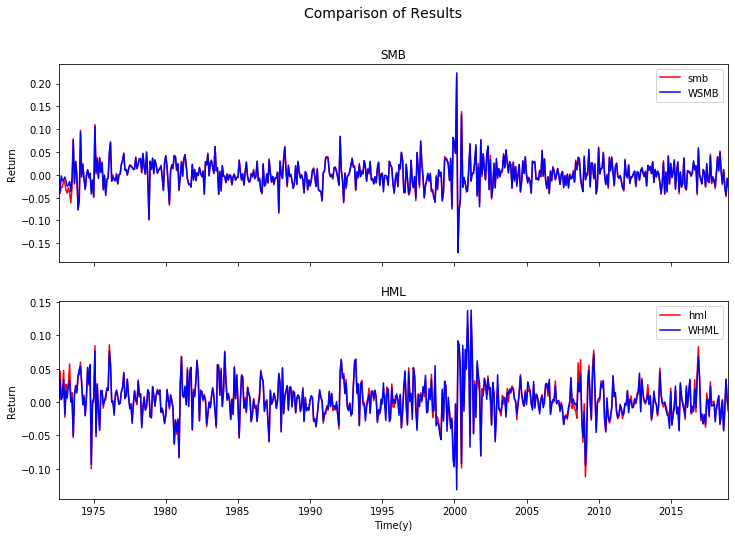

In [130]:
import datetime
plt.figure(figsize=(12,8)) 
plt.suptitle("Comparison of Results", fontsize=14)

ax1=plt.subplot(2, 1, 1)
plt.ylabel("Return")
plt.title("SMB")
plt.plot(_ffcomp70['date'],_ffcomp70['smb'],label = 'smb',color='red')
plt.plot(_ffcomp70['date'],_ffcomp70['WSMB'], label = 'WSMB',color='blue')
plt.legend(loc="best")
ax1.set_xlim([datetime.date(1972, 7, 31), datetime.date(2018, 12, 31)])
plt.setp(ax1.get_xticklabels(), visible=False)

ax2=plt.subplot(2, 1, 2)
plt.xlabel('Time(y)')
plt.ylabel("Return")
plt.title("HML")
plt.plot(_ffcomp70['date'],_ffcomp70['hml'],label = 'hml', color='red')
plt.plot(_ffcomp70['date'],_ffcomp70['WHML'],label = 'WHML', color='blue')
ax2.set_xlim([datetime.date(1972, 7, 31), datetime.date(2018, 12, 31)])
plt.legend(loc="best")
plt.show()

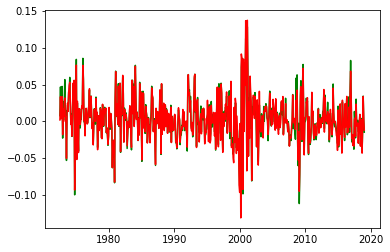